<a href="https://colab.research.google.com/github/veyis/FinGPT/blob/master/stock_timeseries-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/25
16/16 [==============================] - 5s 82ms/step - loss: 0.0452 - val_loss: 0.0108
Epoch 2/25
16/16 [==============================] - 0s 22ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 3/25
16/16 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 4/25
16/16 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 5/25
16/16 [==============================] - 1s 34ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/25
16/16 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 7/25
16/16 [==============================] - 0s 31ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 8/25
16/16 [==============================] - 1s 32ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/25
16/16 [==============================] - 0s 31ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/25
16/16 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 11/

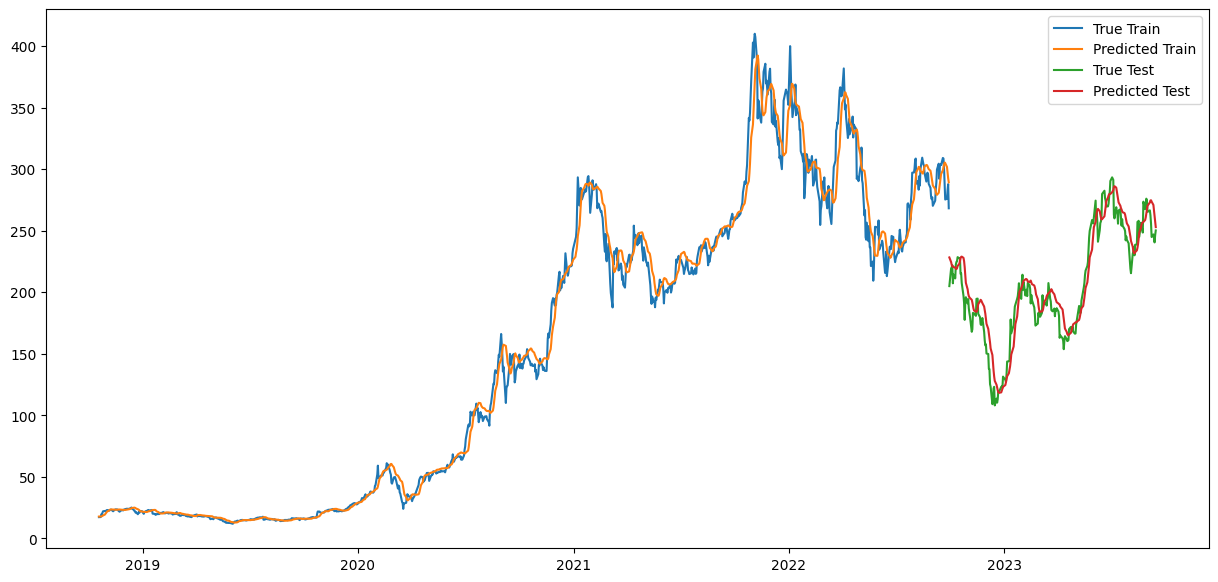

Training RMSE: 12.86194847456066
Testing RMSE: 14.598535452809486


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = 'TSLA2.csv'
tsla_df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format and set it as the index
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
tsla_df.set_index('Date', inplace=True)

# Create lag features and moving average feature
num_lags = 3
window_size = 5
for lag in range(1, num_lags + 1):
    tsla_df[f'lag_{lag}'] = tsla_df['Close'].shift(lag)
tsla_df['moving_avg'] = tsla_df['Close'].rolling(window=window_size).mean()
tsla_df.dropna(inplace=True)

# Split the data into training and testing sets
test_size = 0.2
train_df = tsla_df[:int((1 - test_size) * len(tsla_df))]
test_df = tsla_df[int((1 - test_size) * len(tsla_df)):]

# Scale the features
features = train_df.drop('Close', axis=1).columns.tolist()
target = 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns, index=train_df.index)
test_scaled = scaler.transform(test_df)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns, index=test_df.index)

# Prepare the input data for the LSTM model
def create_lstm_input_data(data, features, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data.iloc[i:(i + timesteps)][features].values)
        y.append(data.iloc[i + timesteps][target])
    return np.array(X), np.array(y)

timesteps = 10
X_train, y_train = create_lstm_input_data(train_scaled_df, features, target, timesteps)
X_test, y_test = create_lstm_input_data(test_scaled_df, features, target, timesteps)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=25, validation_data=(X_test, y_test))

def inverse_transform_predictions(y_pred, X_original, scaler, target='Close'):
    # Create a placeholder DataFrame with the same shape and columns as the original training DataFrame
    placeholder_df = pd.DataFrame(np.zeros((len(y_pred), train_df.shape[1])), columns=train_df.columns)

    # Replace the target column in the placeholder DataFrame with the predicted values
    placeholder_df[target] = y_pred.squeeze()

    # Inverse transform the placeholder DataFrame using the scaler
    y_pred_original = scaler.inverse_transform(placeholder_df)[:, train_df.columns.get_loc(target)]

    return y_pred_original



# Make predictions and inverse transform them
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred_original = inverse_transform_predictions(y_train_pred, X_train, scaler)
y_test_pred_original = inverse_transform_predictions(y_test_pred, X_test, scaler)

# Inverse transform the original target values
y_train_original = inverse_transform_predictions(y_train.reshape(-1, 1), X_train, scaler)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), X_test, scaler)

# Calculate the RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

# Plot the results
plt.figure(figsize=(15,7))
plt.plot(train_df.index[-len(y_train_original):], y_train_original, label='True Train')
plt.plot(train_df.index[-len(y_train_original):], y_train_pred_original, label='Predicted Train')
plt.plot(test_df.index[:len(y_test_original)], y_test_original, label='True Test')
plt.plot(test_df.index[:len(y_test_original)], y_test_pred_original, label='Predicted Test')
plt.legend()
plt.show()

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')


In [ ]:
# 1. Prepare the input data
latest_data = tsla_df[-timesteps:]  # Get the most recent data points

# 2. Scale and reshape the input data
latest_scaled = scaler.transform(latest_data)
latest_scaled_df = pd.DataFrame(latest_scaled, columns=latest_data.columns, index=latest_data.index)

X_latest, _ = create_lstm_input_data(latest_scaled_df, features, target, timesteps)
X_latest = X_latest[0].reshape(1, timesteps, -1)  # The model expects input shape (batch_size, timesteps, num_features)

# 3. Make the prediction
next_day_pred = model.predict(X_latest)

# 4. Inverse the preprocessing steps
next_day_pred_original = inverse_transform_predictions(next_day_pred, X_latest, scaler)

print(f"The predicted closing price for the next day is: {next_day_pred_original[0]}")


IndexError: ignored

# New Section